## TODO
- [x] Store embeddings of one sample for each voice from the whole test set in a optimized vector store, faiss ( save to mounted drive )
- [x] Run experiment, basic similarity (could be average of samples (cosine similarity->mean) or the first one)
- [x] Run experiment, query with different levels of noise against vector store
- [x] Run experiment, query with average of multiple samples from the same audio segment (mean of embeddings -> cosine similarity) (is the cosine similarity to mean of vectors the same as the mean of cosine similarities?)
- [x] Extract faces from the videos or find a mapping between celebrity ids and names.
- [x] Downloading and processing more data, deciding how much we need (potentially ranking the most popular celebrities, or choosing those which have a lot of data)

- [ ] Re-create storage with all segments from one part of the video.
- [ ] Experiment with different threshold values for rejecting a match on.
- [ ] Create a second storage with all 6000 celebrities.
- [ ] Download longest segment for all videos of top 200 celebrities.
- [ ] Experiment by gradually adding more segments to the storage for the dataset of 200 celebrities, calculate accuracy, make plot.
- [ ] Copy vector to store to local machine, create a script ( website ) that computes and visualizes the embeddings in 2d using tsne. And allows for live recording and comparison, linking to youtube segment of the closest person.

- [ ] Write the report with the created plots and results.

*Experiments should contain some visualization, seaborn plots.*

Load repo

In [1]:
%%capture
!rm -r sample_data
# load our repository
!rm -r DT2112/
!git clone https://github.com/viktor-kth/DT2112.git
!git pull
# install all dependencies
!pip install --upgrade pip setuptools
!pip install --upgrade DT2112/


In [2]:

import random
import gdown
import numpy as np
import os

from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

import librosa
import librosa.display
import matplotlib.pyplot as plt
import gdown

from kth_sr.mfcc import first_k_windows
from kth_sr.embeddings import get_embedding_model

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0



## Load model

In [4]:
from pathlib import Path

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Variables
SAMPLE_RATE = 16000
NUM_FRAMES = 160

# Define the model here.
model_path = "ResCNN_triplet_training_checkpoint_265.h5"
model = get_embedding_model(model_path)

# Mount file system
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Downloading...
From: https://drive.google.com/uc?id=1F9NvdrarWZNktdX9KlRYWWHDwRkip_aP
To: /content/ResCNN_triplet_training_checkpoint_265.h5
100%|██████████| 97.1M/97.1M [00:02<00:00, 44.0MB/s]


ValueError: mount failed

In [ ]:
from deep_speaker.audio import read_mfcc, mfcc_fbank, pad_mfcc


def first_k_mfccs(audio, sample_rate, num_frames=NUM_FRAMES, k=1):
  """Call Deep Speaker preprocessing and return first k windows.

  Args:
    audio (ndarray): Audio signal.
    sample_rate (int): Sample rate.
    num_frames (int): Number of frames per segment.
    k (int): Number of segments to return.

  Returns:
    ndarray: First k segments of audio. Shape (k, 160, 64, 1)
  """

  energy = np.abs(audio)
  silence_threshold = np.percentile(energy, 95)
  offsets = np.where(energy > silence_threshold)[0]
  # left_blank_duration_ms = (1000.0 * offsets[0]) // self.sample_rate  # frame_id to duration (ms)
  # right_blank_duration_ms = (1000.0 * (len(audio) - offsets[-1])) // self.sample_rate
  # TODO: could use trim_silence() here or a better VAD.
  audio_voice_only = audio[offsets[0]:offsets[-1]]
  mfcc = mfcc_fbank(audio_voice_only, sample_rate)

  segments = []
  for i in range(k):
    start_frame = i * num_frames
    end_frame = start_frame + num_frames

    if end_frame > mfcc.shape[0]:
      # padded = pad_mfcc(mfcc[i * num_frames :], num_frames)
      # segments.append(padded)
      break

    segments.append(mfcc[start_frame:end_frame])

  return np.array(segments).reshape((-1, 160, 64, 1))

## Getting file paths

In [ ]:
from os.path import split
import os

folder_path = "/content/drive/My Drive/KTH/DT2112/Project/Dataset/filtered_celebs_data"  # Add a shortcut in drive to match the same path

print(len(os.listdir(folder_path)))

# Get all audio files
all_files = sorted([ f for f in os.listdir(folder_path) if f.endswith(('.mp3'))])
celeb_files = []
for i in range(0, len(all_files), 10):
  celeb_files.append(all_files[i:i+10])

for files in celeb_files:
  assert all(file[:7] == files[0][:7] for file in files)

2000


## Get MFCCs

In [ ]:
# Calculate MFCCs for all celeb_files
celeb_mfccs = []
min_query_segments = np.inf
for files in celeb_files:
  celeb_mfccs.append([])
  for file in files:
    file_path = os.path.join(folder_path, file)
    celeb_id = file.split("_")[0]
    clip_id = file.split("_")[1]

    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    mfccs = first_k_mfccs(signal, sr, NUM_FRAMES, k=10000)
    celeb_mfccs[-1].append((mfccs, celeb_id, clip_id))
    min_query_segments = min(min_query_segments, len(mfccs))
min_query_segments

4

In [ ]:
print(len(celeb_mfccs))
for i in range(len(celeb_mfccs)):
  assert len(celeb_mfccs[i]) == 10

for i in range(10):
  print(celeb_mfccs[0][i][1:])

200
('id00020', '0')
('id00020', '1')
('id00020', '2')
('id00020', '3')
('id00020', '4')
('id00020', '5')
('id00020', '6')
('id00020', '7')
('id00020', '8')
('id00020', '9')


In [ ]:
import faiss
import numpy as np
import json
import os

from kth_sr.vectorstore import FAISS

embedding_dim = 512
vstore = FAISS(embedding_dim)

In [ ]:
def calculate_accuracy(embeddings, true_labels):
    distances, results = vstore.search(embeddings, k=1)
    predicted_labels = [res[0] for res in results]
    accuracy = sum(p == t for p, t in zip(predicted_labels, true_labels)) / len(embeddings)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [ ]:
# Storage and accuracy tracking
accuracies = []
all_embeddings = {}

In [ ]:
query_embeddings = []
query_labels = []

for speaker in range(len(celeb_mfccs)):
    speaker_id, clip_id = celeb_mfccs[speaker][0][1:]

    if (speaker_id, clip_id) not in all_embeddings:
      mfccs = celeb_mfccs[speaker][0][0][:min_query_segments] # Using first 4 segments
      embeddings = model.m.predict(mfccs, verbose=None)
      query_embeddings.append(np.mean(embeddings, axis=0))
      all_embeddings[(speaker_id, clip_id)] = query_embeddings[-1]
      query_labels.append(speaker_id)
    else:
      query_embeddings.append(all_embeddings[(speaker_id, clip_id)])
      query_labels.append(speaker_id)


In [ ]:
for n in range(1, 10):
  # Rebuild FAISS index
  vstore._vstore.reset()

  for speaker in range(len(celeb_mfccs)):
    speaker_embeddings = []
    speaker_id = None
    for clip in celeb_mfccs[speaker][1:n+1]:
      label = clip[1:]
      speaker_id = label[0]
      if label not in all_embeddings: # Using first 4 segments
        mfccs = clip[0][:min_query_segments]
        embeddings = model.m.predict(mfccs, verbose=False)
        all_embeddings[label] = np.mean(embeddings, axis=0)
      speaker_embeddings.append(all_embeddings[label])
    vstore.add([np.mean(speaker_embeddings, axis=0)], [speaker_id])
  vstore.save(f"{folder_path}/celebs_200_{n}_clips")

  print(f"{n}: ", end="")
  accuracy = calculate_accuracy(query_embeddings, query_labels)
  accuracies.append(accuracy)

1: Accuracy: 0.2100
2: Accuracy: 0.5150
3: Accuracy: 0.5300
4: Accuracy: 0.5850
5: Accuracy: 0.6100
6: Accuracy: 0.6150
7: Accuracy: 0.6500
8: Accuracy: 0.6550
9: Accuracy: 0.6550


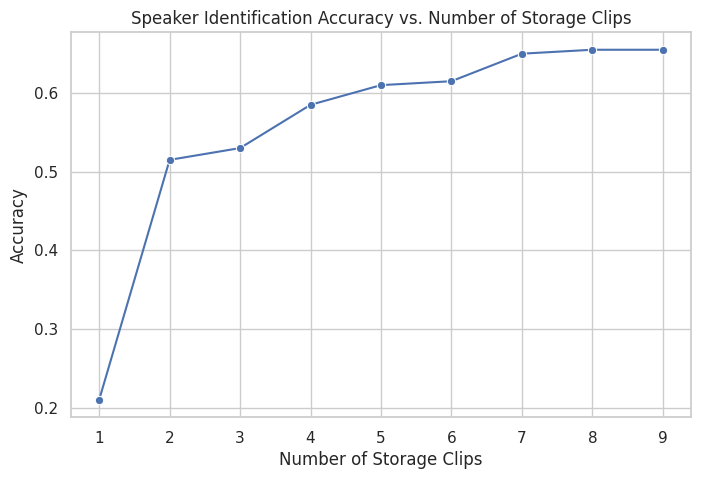

In [ ]:
import seaborn as sns

# Plot results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1,10)), y=accuracies, marker="o")
plt.xlabel("Number of Storage Clips")
plt.ylabel("Accuracy")
plt.title("Speaker Identification Accuracy vs. Number of Storage Clips")
plt.show()

### Noise Impact

In [ ]:
# Function to add Gaussian noise
def add_noise(signal, noise_level):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

# Parameters
noise_levels = np.linspace(0, 0.05, 9)  # Different noise levels
accuracies_with_noise = []

# Iterate over noise levels
for noise_level in noise_levels:
    print(f"Noise level {noise_level} - ", end="")
    query_embeddings = []
    query_labels = []

    # Process query files with noise
    for speaker in range(len(celeb_mfccs)):
        speaker_id, clip_id = celeb_mfccs[speaker][0][1:]
        file_path = os.path.join(folder_path, celeb_files[speaker][0])
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        noisy_signal = add_noise(signal, noise_level)
        mfccs = first_k_mfccs(noisy_signal, sr, NUM_FRAMES, k=10000)
        mfccs = mfccs[:min_query_segments]
        embeddings = model.m.predict(mfccs, verbose=None)
        query_embeddings.append(np.mean(embeddings, axis=0))
        query_labels.append(speaker_id)

    # Evaluate accuracy for this noise level
    vstore._vstore.reset()
    for speaker in range(len(celeb_mfccs)):
        speaker_embeddings = []
        speaker_id = None
        for clip in celeb_mfccs[speaker][1:10]:  # Up to 9 files
            label = clip[1:]
            speaker_id = label[0]
            if label not in all_embeddings: # Using first 4 segments
                mfccs = clip[0][:min_query_segments]
                embeddings = model.m.predict(mfccs, verbose=False)
                all_embeddings[label] = np.mean(embeddings, axis=0)
            speaker_embeddings.append(all_embeddings[label])
        vstore.add([np.mean(speaker_embeddings, axis=0)], [speaker_id])

    accuracy = calculate_accuracy(query_embeddings, query_labels)
    accuracies_with_noise.append(accuracy)


Noise level 0.0 - Accuracy: 0.6550
Noise level 0.00625 - Accuracy: 0.1950
Noise level 0.0125 - Accuracy: 0.0750
Noise level 0.018750000000000003 - Accuracy: 0.0400
Noise level 0.025 - Accuracy: 0.0250
Noise level 0.03125 - Accuracy: 0.0200
Noise level 0.037500000000000006 - Accuracy: 0.0250
Noise level 0.043750000000000004 - Accuracy: 0.0150
Noise level 0.05 - Accuracy: 0.0150


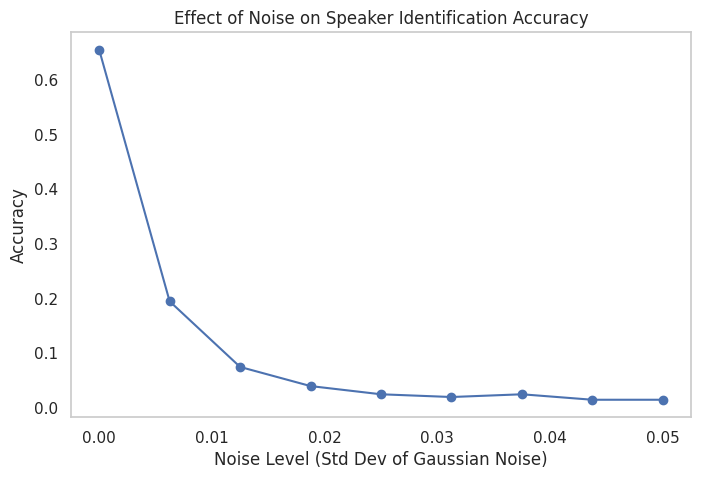

In [ ]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, accuracies_with_noise, marker='o', linestyle='-', color='b')
plt.xlabel("Noise Level (Std Dev of Gaussian Noise)")
plt.ylabel("Accuracy")
plt.title("Effect of Noise on Speaker Identification Accuracy")
plt.grid()
plt.show()